In [102]:
%matplotlib inline
import requests
from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numba import guvectorize
from scipy import signal
from scipy import stats as ss

# utils functions
# ===============

def get_prices(coin_symbol):
    """Get close price.

    Given a symbol crytocurrency retrieve last 2k close prices in USD.

    Parameters
    ----------
    coin_symbol : str

    Returns
    -------
    price_close : pandas.DataFrame
    """
    endpoint = "https://min-api.cryptocompare.com/data/histoday"
    params1 = dict(fsym=coin_symbol, tsym="USD",limit=2000, aggregate=1)
    out1 = requests.get(endpoint, params=params1).json()['Data']
    data1 = pd.DataFrame(out1).set_index('time').loc[:, ['close']].rename(columns=dict(close=coin_symbol))
    params2 = dict(fsym=coin_symbol, tsym="USD",limit=2000, toTs=min(data1.index), aggregate=1)
    out2 = requests.get(endpoint, params=params2).json()['Data']
    data2 = pd.DataFrame(out2).set_index('time').loc[:, ['close']].rename(columns=dict(close=coin_symbol))
    frames = [data1, data2]
    return data2.combine_first(data1)


def get_symbol_close(coin_symbol_list):
    """Get symbol close.

    Given a list of cryptocurrencies symbols retrieve close prices.

    Parameters
    ----------
    coin_symbol_list : list

    Returns
    -------
    price_close : pandas.DataFrame
    """
    d = [get_prices(coin_sym) for coin_sym in coin_symbol_list]
    out = pd.concat(d, axis=1)
    out.index = out.index.map(datetime.utcfromtimestamp)
    return out.asfreq(out.index.inferred_freq)


def multi_column_df_display(list_dfs, cols=3):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)
    cells = [html_cell.format(content=df.to_html()) for df in list_dfs]
    cells += (cols - (len(list_dfs) % cols)) * [html_cell.format(content="")]
    rows = [html_row.format(content="".join(cells[i:i+cols])) for i in range(0, len(cells), cols)]
    display(HTML(html_table.format(content="".join(rows))))

# hurst functions
# ===============
@guvectorize("float64[:], int64, int64, int64, float64[:]", "(m),(),(),()->()",
             cache=True, nopython=True)
def hurst_rs(x, min_chunksize, max_chunksize, num_chunksize, out):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the R/S method from the time series.
    The R/S method consists of dividing the series into pieces of equal size
    `series_len` and calculating the rescaled range. This repeats the process
    for several `series_len` values and adjusts data regression to obtain the H.
    `series_len` will take values between `min_chunksize` and `max_chunksize`,
    the step size from `min_chunksize` to `max_chunksize` can be controlled
    through the parameter `step_chunksize`.

    Parameters
    ----------
    x : 1D-array
        A time series to calculate hurst exponent, must have more elements
        than `min_chunksize` and `max_chunksize`.
    min_chunksize : int
        This parameter allow you control the minimum window size.
    max_chunksize : int
        This parameter allow you control the maximum window size.
    num_chunksize : int
        This parameter allow you control the size of the step from minimum to
        maximum window size. Bigger step means fewer calculations.
    out : 1-element-array, optional
        one element array to store the output.

    Returns
    -------
    H : float
        A estimation of Hurst exponent.

    References
    ----------
    Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
    Transactions, 116(776), 770-808.
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150
    """
    N = len(x)
    max_chunksize += 1
    rs_tmp = np.empty(N, dtype=np.float64)
    chunk_size_list = np.linspace(min_chunksize, max_chunksize, num_chunksize)\
                        .astype(np.int64)
    rs_values_list = np.empty(num_chunksize, dtype=np.float64)

    # 1. The series is divided into chunks of chunk_size_list size
    for i in range(num_chunksize):
        chunk_size = chunk_size_list[i]

        # 2. it iterates on the indices of the first observation of each chunk
        number_of_chunks = int(len(x) / chunk_size)

        for idx in range(number_of_chunks):
            # next means no overlapping
            # convert index to index selection of each chunk
            ini = idx * chunk_size
            end = ini + chunk_size
            chunk = x[ini:end]

            # 2.1 Calculate the RS (chunk_size)
            z = np.cumsum(chunk - np.mean(chunk))
            rs_tmp[idx] = np.divide(
                np.max(z) - np.min(z),  # range
                np.nanstd(chunk)  # standar deviation
            )

        # 3. Average of RS(chunk_size)
        rs_values_list[i] = np.nanmean(rs_tmp[:idx + 1])

    # 4. calculate the Hurst exponent.
    H, c = np.linalg.lstsq(
        a=np.vstack((np.log(chunk_size_list), np.ones(num_chunksize))).T,
        b=np.log(rs_values_list)
    )[0]

    out[0] = H


def hurst_dma(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the DMA method from the time series.
    The DMA method consists on calculate the moving average of size `series_len`
    and subtract it to the original series and calculating the standard
    deviation of that result. This repeats the process for several `series_len`
    values and adjusts data regression to obtain the H. `series_len` will take
    values between `min_chunksize` and `max_chunksize`, the step size from
    `min_chunksize` to `max_chunksize` can be controlled through the parameter
    `step_chunksize`.

    Parameters
    ----------
    prices
    min_chunksize
    max_chunksize
    num_chunksize

    Returns
    -------
    hurst_exponent : float
        Estimation of hurst exponent.

    References
    ----------
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150

    """
    max_chunksize += 1
    N = len(prices)
    n_list = np.arange(min_chunksize, max_chunksize, num_chunksize, dtype=np.int64)
    dma_list = np.empty(len(n_list))
    factor = 1 / (N - max_chunksize)
    # sweeping n_list
    for i, n in enumerate(n_list):
        b = np.divide([n - 1] + (n - 1) * [-1], n)  # do the same as:  y - y_ma_n
        noise = np.power(signal.lfilter(b, 1, prices)[max_chunksize:], 2)
        dma_list[i] = np.sqrt(factor * np.sum(noise))

    H, const = np.linalg.lstsq(
        a=np.vstack([np.log10(n_list), np.ones(len(n_list))]).T,
        b=np.log10(dma_list)
    )[0]
    return H


def hurst_dsod(x):
    """Estimate Hurst exponent on data timeseries.

    The estimation is based on the discrete second order derivative. Consists on
    get two different noise of the original series and calculate the standard
    deviation and calculate the slope of two point with that values.
    source: https://gist.github.com/wmvanvliet/d883c3fe1402c7ced6fc

    Parameters
    ----------
    x : numpy array
        time series to estimate the Hurst exponent for.

    Returns
    -------
    h : float
        The estimation of the Hurst exponent for the given time series.

    References
    ----------
    Istas, J.; G. Lang (1994), “Quadratic variations and estimation of the local
    Hölder index of data Gaussian process,” Ann. Inst. Poincaré, 33, pp. 407–436.


    Notes
    -----
    This hurst_ets is data literal traduction of wfbmesti.m of waveleet toolbox
    from matlab.
    """
    y = np.cumsum(np.diff(x, axis=0), axis=0)

    # second order derivative
    b1 = [1, -2, 1]
    y1 = signal.lfilter(b1, 1, y, axis=0)
    y1 = y1[len(b1) - 1:]  # first values contain filter artifacts

    # wider second order derivative
    b2 = [1,  0, -2, 0, 1]
    y2 = signal.lfilter(b2, 1, y, axis=0)
    y2 = y2[len(b2) - 1:]  # first values contain filter artifacts

    s1 = np.mean(y1 ** 2, axis=0)
    s2 = np.mean(y2 ** 2, axis=0)

    return 0.5 * np.log2(s2 / s1)


def hurst_exponent(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5,
                   method='RS'):
    """Estimates Hurst Exponent.

    Estimate the hurst exponent following one of 3 methods. Each method

    Parameters
    ----------
    prices : numpy.ndarray, pandas.Series or pandas.DataFrame
        A time series to estimate hurst exponent.
    min_chunksize : int, optional
        Minimum chunk  size of the original series. This parameter doesn't have
        any effect with DSOD method.
    max_chunksize : int, optional
        Maximum chunk size of the original series. This parameter doesn't have
        any effect with DSOD method.
    step_chunksize : int, optional
        Step used to select next the chunk size which divide the original
        series. This parameter doesn't have any effect with DSOD method.
    method : {'RS', 'DMA', 'DSOD', 'all'}
        The methods can take one of that values,
            RS : rescaled range.
            DMA : deviation moving average.
            DSOD : discrete second order derivative.


    Returns
    -------
    hurst_exponent : float
        Estimation of hurst_exponent according to the method selected.

    References
    ----------
    RS : Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
         Transactions, 116(776), 770-808.
    DMA : Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002)
         27: 197. http://dx.doi.org/10.1140/epjb/e20020150
    DSOD : Istas, J.; G. Lang (1994), “Quadratic variations and estimation of
        the local Hölder index of data Gaussian process,” Ann. Inst. Poincaré,
        33, pp. 407–436.

    Notes
    -----
    The hurst exponent is an estimation which is important because there is no
    data closed equation for it instead we have some methods to estimate it with
    high variations among them.

    See Also
    --------
    hurst_rs, hurst_dma, hurst_dsod
    """
    if len(prices) == 0:
        return np.nan
    # extract array
    arr = prices.__array__()
    # choose data method
    if method == 'RS':
        if prices.ndim > 1:
            h = hurst_rs(np.diff(arr, axis=0).T, min_chunksize, max_chunksize,
                         num_chunksize)
        else:
            h = hurst_rs(np.diff(arr), min_chunksize, max_chunksize,
                         num_chunksize)
    elif method == 'DMA':
        h = hurst_dma(arr, min_chunksize, max_chunksize, num_chunksize)
    elif method == 'DSOD':
        h = hurst_dsod(arr)
    elif method == 'all':
        return [
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'RS'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DMA'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DSOD')
        ]
    else:
        raise NotImplementedError('The method choose is not implemented.')
    
    return h

To show about about persistence we can follow similiar steps as shown in the paper [Persistence in the cryptocurrency market](https://www.sciencedirect.com/science/article/pii/S0275531917309200). I select the same four currencies selected in that paper, that is: Bitcoin, Ethereum, Dash and Litecoin.

You can see [here](https://coinmarketcap.com/coins/) the top crypto currencies by market capitalization.

In [103]:
coin_sym_list = 'BTC ETH DASH LTC'.split()
prices = get_symbol_close(coin_sym_list)
prices = prices.loc['2013':'2022']  # select the same period
prices = prices.where(prices != 0., np.nan)  # convert zeros into NaN's

In [104]:
multi_column_df_display([prices.head(), prices.tail()], 2)

,BTC,ETH,DASH,LTC
time,,,,
2013-01-01,13.30,NaN,NaN,NaN
2013-01-02,13.28,NaN,NaN,NaN
2013-01-03,13.40,NaN,NaN,NaN
2013-01-04,13.50,NaN,NaN,NaN
2013-01-05,13.44,NaN,NaN,NaN
,BTC,ETH,DASH,LTC
time,,,,
2022-05-12,28915.72,1952.81,53.63,64.22
2022-05-13,29244.83,2006.51,58.00,67.77


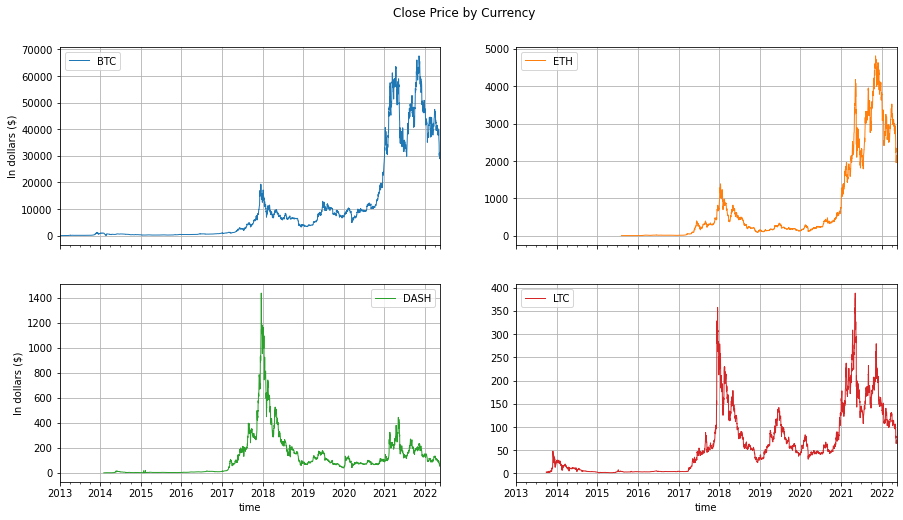

In [105]:
# plot price series
kw = dict(figsize=(15,8), grid=True, subplots=True, layout=(2,2), linewidth=1)
axs = prices.plot(**kw)
[ax.set_ylabel('In dollars ($)') for ax in axs.flat[::2]]
plt.suptitle('Close Price by Currency', y=0.95);

In [106]:
# table hurst with entire series
hurst_methods = [
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DSOD', min_chunksize=4, max_chunksize=30)),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='RS', min_chunksize=4, max_chunksize=30)),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DMA', min_chunksize=4, max_chunksize=30)),
]
hurst_table = pd.concat(hurst_methods, axis=1)
hurst_table.columns = ['DSOD', 'RS', 'DMA']
hurst_table

/tmp/ipykernel_210927/346325628.py:192: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H, const = np.linalg.lstsq(


,DSOD,RS,DMA
BTC,0.454910,0.614495,0.610879
ETH,0.389861,0.621132,0.583973
DASH,0.394934,0.607353,0.617666
LTC,0.462289,0.604567,0.592800


In [107]:
# the same methodology as shown in the paper.
roll_days = 300
roll_prices = prices.rolling(roll_days)
summary = [
    roll_prices.apply(lambda s: hurst_exponent(s, method='RS', min_chunksize=4, max_chunksize=30)),
    roll_prices.apply(lambda s: hurst_exponent(s, method='DSOD', min_chunksize=4, max_chunksize=30)),
    roll_prices.apply(lambda s: hurst_exponent(s, method='DMA', min_chunksize=4, max_chunksize=30)),
    ]
roll_hurst = pd.concat(summary, axis=1, keys=['RS', 'DSOD', 'DMA'])
roll_hurst = roll_hurst.swaplevel(axis=1)\
                       .asfreq(roll_hurst.index.inferred_freq)\
                       .sort_index(axis=1, level=0)

/tmp/ipykernel_210927/346325628.py:192: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H, const = np.linalg.lstsq(


In [108]:
roll_hurst[::50].tail()

BTC                          DASH                      \
                 DMA      DSOD        RS       DMA      DSOD        RS   
time                                                                     
2021-10-06  0.576800  0.395533  0.612713  0.590705  0.115605  0.601338   
2021-11-25  0.589870  0.388622  0.634800  0.568358  0.130386  0.629029   
2022-01-14  0.622100  0.451709  0.597470  0.585053  0.207972  0.602948   
2022-03-05  0.572705  0.514020  0.625222  0.573880  0.135840  0.633740   
2022-04-24  0.595289  0.618216  0.627960  0.562239  0.494657  0.617433   

                 ETH                           LTC                      
                 DMA      DSOD        RS       DMA      DSOD        RS  
time                                                                    
2021-10-06  0.578350  0.290804  0.607280  0.557268  0.326333  0.622030  
2021-11-25  0.587651  0.303078  0.630566  0.547804  0.332611  0.672727  
2022-01-14  0.572097  0.353994  0.573088  0.562258  0.326443  0.623762  
2022-03-05  0.552895  0.408615  0.621569  0.518505  0.286883  0.654390  
2022-04-24  0.566976  0.542039  0.584531  0.517742  0.593225  0.653738

In [109]:
roll_hurst[::50].mean()

BTC   DMA     0.603968
      DSOD    0.514168
      RS      0.617401
DASH  DMA     0.556554
      DSOD    0.367716
      RS      0.602527
ETH   DMA     0.610806
      DSOD    0.432371
      RS      0.623814
LTC   DMA     0.546719
      DSOD    0.459975
      RS      0.604183
dtype: float64

In [110]:
roll_hurst[::50].median()

BTC   DMA     0.601389
      DSOD    0.527422
      RS      0.621299
DASH  DMA     0.593252
      DSOD    0.410054
      RS      0.607674
ETH   DMA     0.612302
      DSOD    0.411292
      RS      0.623834
LTC   DMA     0.562258
      DSOD    0.495588
      RS      0.603796
dtype: float64

In [111]:
roll_hurst[::50].mean(level=0, axis=1);

/tmp/ipykernel_210927/3185004958.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  roll_hurst[::50].mean(level=0, axis=1);


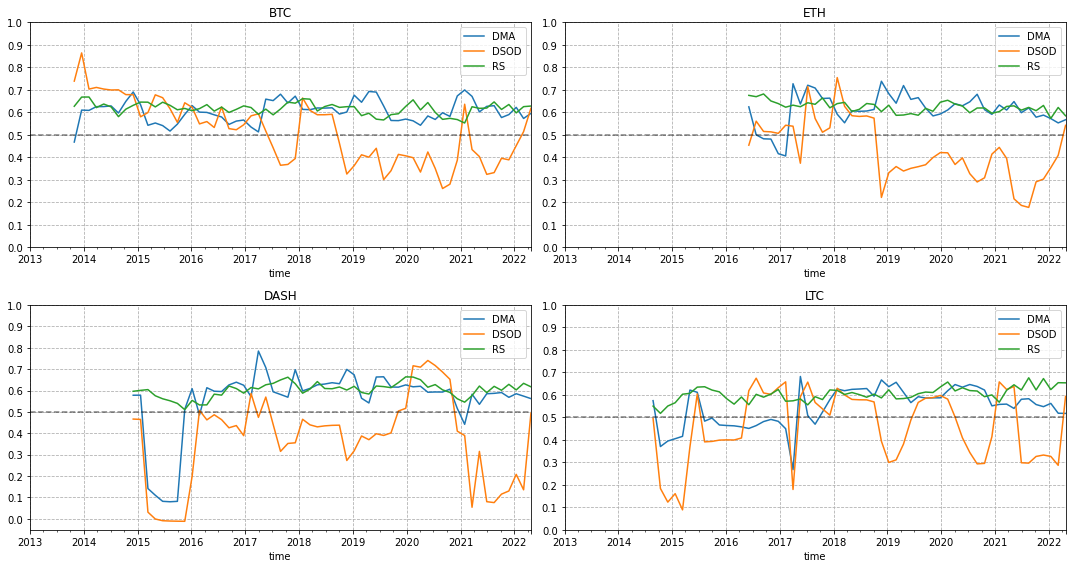

In [112]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::50].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [113]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(50).mean()
ma_roll_hurst.tail()

BTC                          DASH                      \
                 DMA      DSOD        RS       DMA      DSOD        RS   
time                                                                     
2022-05-12  0.586376  0.610079  0.606447  0.556880  0.489248  0.612346   
2022-05-13  0.586303  0.609601  0.606010  0.556936  0.490027  0.611929   
2022-05-14  0.586241  0.609243  0.605565  0.556930  0.491049  0.611517   
2022-05-15  0.586172  0.608922  0.605849  0.556868  0.492024  0.611641   
2022-05-16  0.586170  0.608728  0.606316  0.556794  0.493234  0.612295   

                 ETH                           LTC                      
                 DMA      DSOD        RS       DMA      DSOD        RS  
time                                                                    
2022-05-12  0.557628  0.538841  0.596395  0.514738  0.597059  0.643972  
2022-05-13  0.557404  0.538430  0.596101  0.514578  0.596281  0.643315  
2022-05-14  0.557207  0.538049  0.596037  0.514427  0.595503  0.642678  
2022-05-15  0.556978  0.537699  0.596114  0.514261  0.594709  0.642390  
2022-05-16  0.556792  0.537421  0.596232  0.514115  0.594054  0.642484

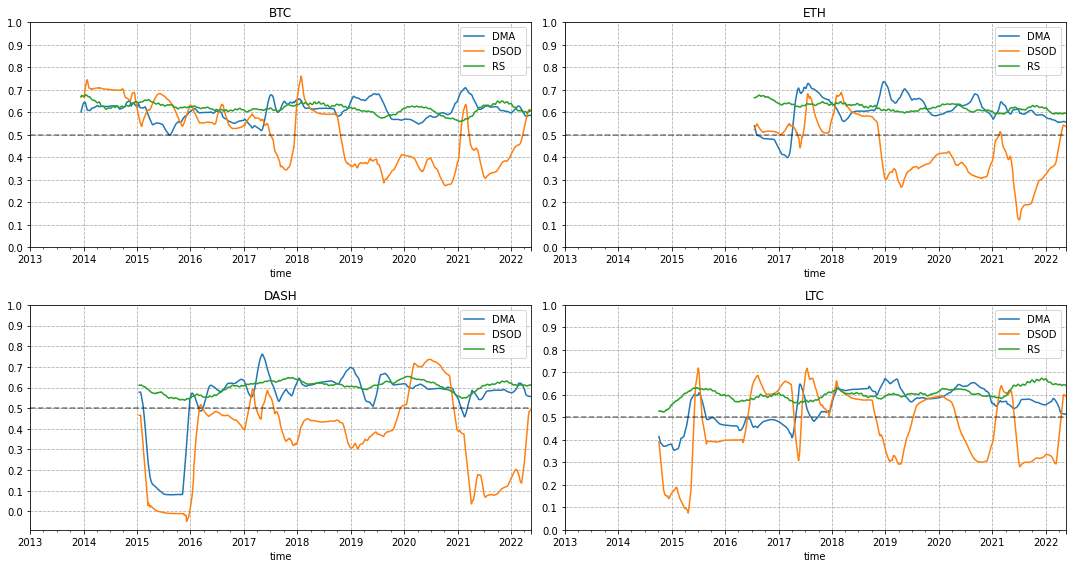

In [114]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(50).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

# REFERENCES

- Caporale, G. M., Gil-Alana, L., & Plastun, A. (2017). Persistence in the Cryptocurrency Market. https://www.sciencedirect.com/science/article/pii/S0275531917309200
- H.E. Hurst, 1951, “Long-term storage of reservoirs: an experimental study,” Transactions of the American Society of Civil Engineers, Vol. 116, pp. 770-799.
- Bo Qian, Khaled Rasheed, 2004, “Hurst Exponent and financial market predictability,” IASTED conference on “Financial Engineering and Applications”(FEA 2004), pp. 203-209,
- Mandelbrot, Benoit B., 2004, “The (Mis)Behavior of Markets, A Fractal View of Risk, Ruin and Reward,” Basic Books, 2004.
